# Calculate buoyancy frequency profiles, WKB limit and ultimately vertical modes

In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta
# import filtering
import numpy as np
import dask
from dask.distributed import Client,default_client
import xrft


def startdask():
    try:
    # Try to get the existing Dask client
        client = default_client()
        print(client)
    except ValueError:
        # If there's no existing client, create a new one
        client = Client()
        print(client)
    return client

client = startdask()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38221 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:42433' processes=7 threads=28, memory=112.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38221/status,
Dashboard: /proxy/38221/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42433,Workers: 7
Dashboard: /proxy/38221/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:40363,Total threads: 4
Dashboard: /proxy/44101/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:39565,


## First draft a function to calculate N(z)

$ \large N = \frac{-g}{\rho}\frac{\partial \rho}{\partial z} $


In [2]:
data = tt.collect_data(exptname="blank-20",rawdata = ["rho","u"],timerange = (1000 - 10,1000 + 10)).sel(yb = slice(-50,50),xb = slice(200,1200)).load()


loading rho...	done.
loading u...	done.
0.3.0


In [3]:
def calculate_N(rho):
    """
    Calculate the buoyancy frequency given density rho in z* coords"""
    N = np.sqrt(
        ((9.8 / rho) * rho.differentiate("zl"))
        ).rename("N")
    N.attrs = {"units":"s^-1"}
    return N



## Calculate the vertical modes

$ \huge \phi_n = \sqrt{\frac{2N}{h\overline{N}}} \cos{\int^z_{-H}} \frac{N(z)}{c_n} dz' $

$ \huge c_n = \frac{h \overline{N}}{n \pi} $

$ \huge u_n(x,y,z,t) = \int^0_H u \phi_n dz$


In [35]:
import scipy

def VerticalModes(data):
    H = np.abs(data.bathy.mean("xb").mean("yb")).values
    N = calculate_N(data.rho).mean("time").mean("xb").mean("yb")
    N.values = np.linspace(N[0],N[-1],len(N))
    # H = np.abs(data.bathy).values
    # N = calculate_N(data.rho).mean("time")
    # H = np.abs(data.bathy).values
    # N = calculate_N(data.rho)


    # Use np.apply_along_axis to prevent averaging over N and H!
    for n in range(10):
        Nbar = N.mean("zl")
        c_n = H * Nbar / (np.pi * n)

        integrated = (N * 0) + scipy.integrate.cumulative_trapezoid(
            (n * N * np.pi) / (H * Nbar),x = data.zl.values,
            initial = 0)
        phi_n = (np.sqrt(
            2 * N / (H * Nbar)
        ) * np.cos(
            integrated
        )).fillna(0)
        modes[n] = (data.u.fillna(0) * phi_n).integrate("zl") * phi_n

    return modes


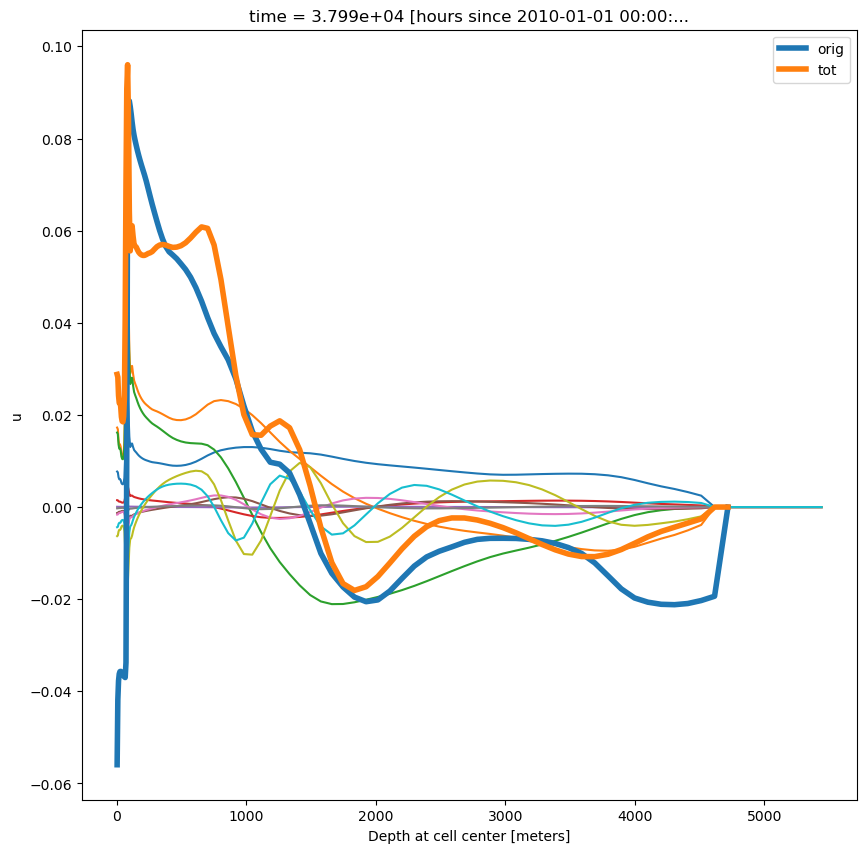

In [60]:
fig,ax = plt.subplots(1,figsize = (10,10))
tot = data.u.isel(time = 0,xb = 0,yb = 0) * 0
for i in modes:
    modes[i].isel(time = 0,xb = 0,yb = 0).plot(ax = ax)
    tot +=  modes[i].isel(time = 0,xb = 0,yb = 0)

data.u.isel(time = 0,xb = 0,yb = 0).plot(ax = ax,label = "orig",linewidth = 4)
tot.plot(ax = ax,label = "tot",linewidth = 4)
plt.legend()

## Try on whole domain

In [8]:
data = tt.collect_data(exptname="blank-20",rawdata = ["rho","u"],timerange = (1000 - 50,1000 + 50)).persist()

# data_lf = xr.open_mfdataset(
#                 f"/g/data/nm03/ab8992/postprocessed/full-20/lfiltered/t0-62655/*.nc",
#                 decode_times = False,
#                 decode_cf = False,
#                 parallel = True)


loading rho...	done.
loading u...	done.


In [36]:
modes = VerticalModes(xr.merge([data.bathy,data.rho,data.u]))

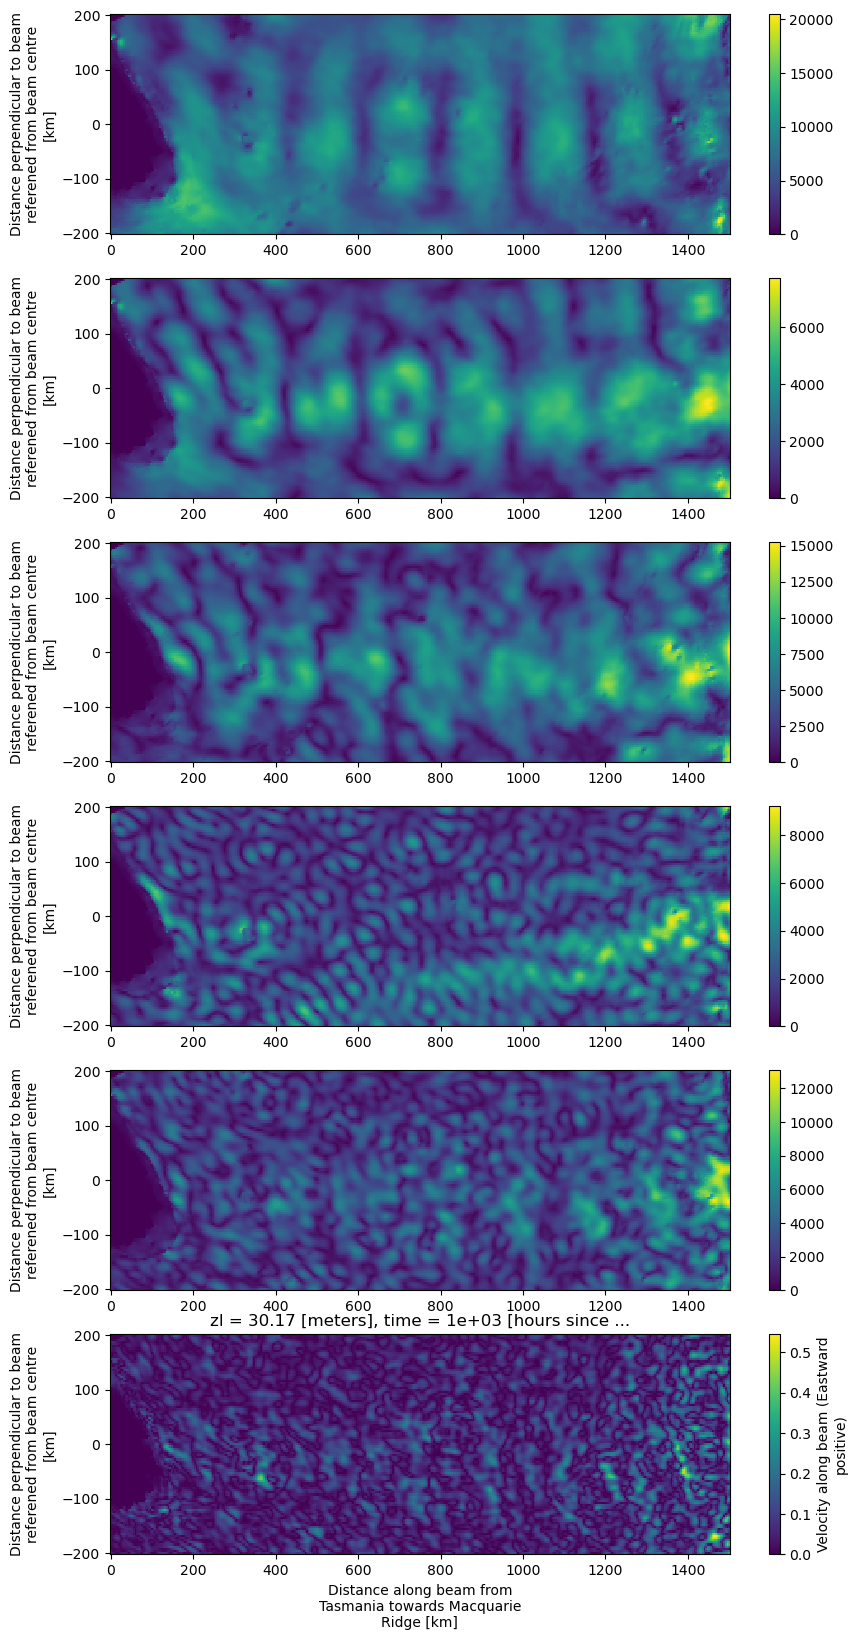

In [ ]:
fig,ax = plt.subplots(6,figsize = (10,20))

for i in range(5):
    np.abs(modes[i]).integrate("zl").integrate("time").plot(ax = ax[i],add_colorbar = True)
    ax[i].set_xlabel("")

np.abs(data.u.isel(time = 50,zl = 5).fillna(0)).plot(ax = ax[5],add_colorbar = True)

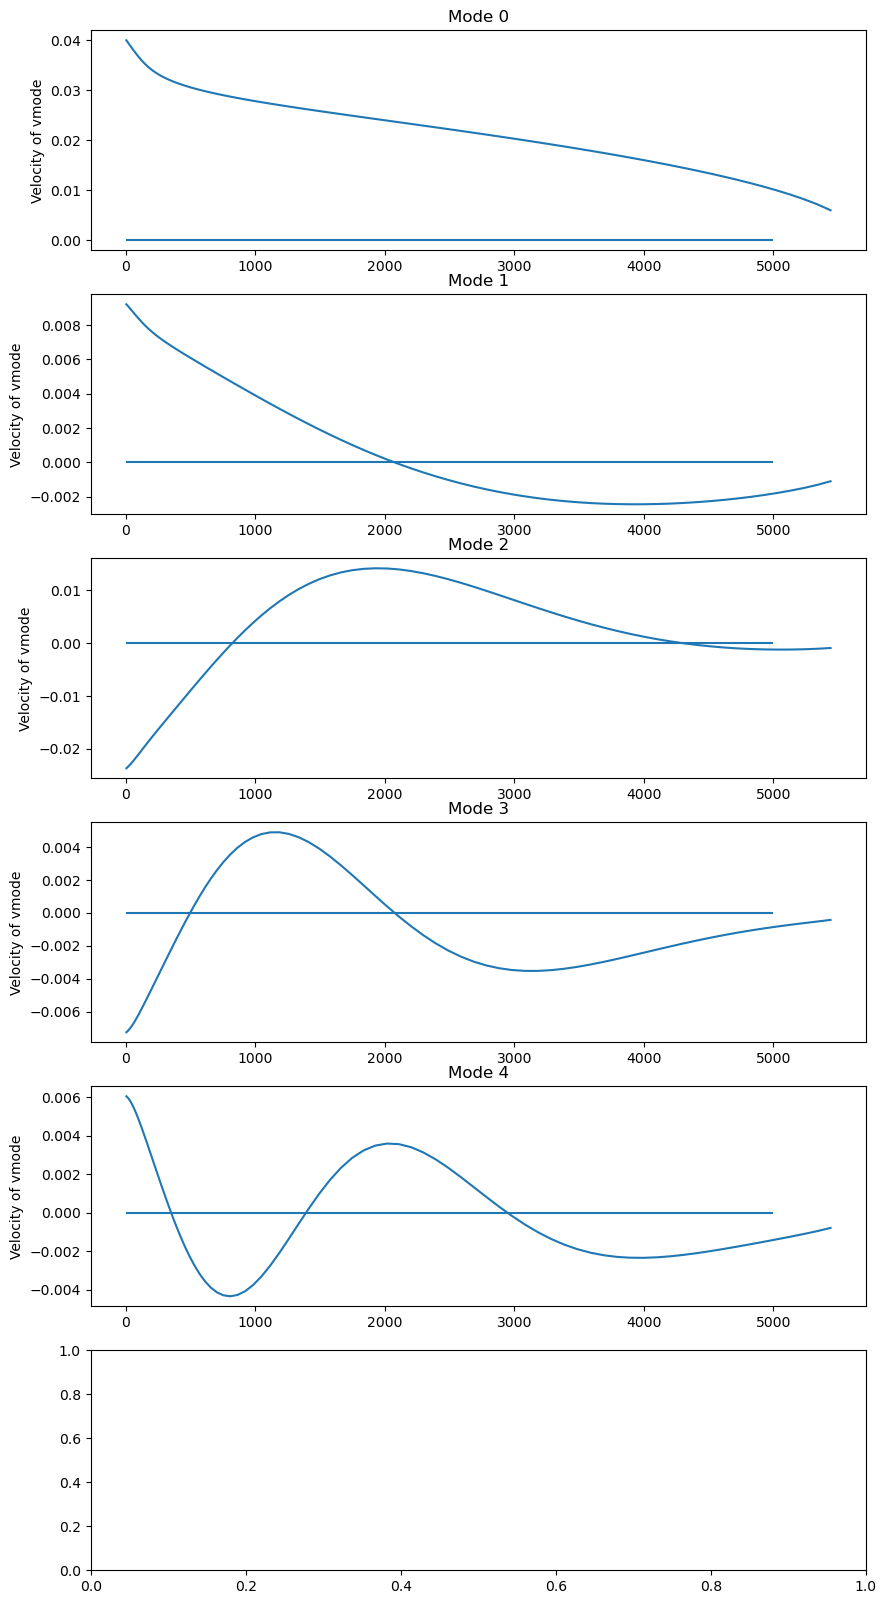

In [37]:
fig,ax = plt.subplots(6,figsize = (10,20))

for i in range(5):
    modes[i].sel(xb = 500,yb = 0,method = "nearest").isel(time = 50).plot(ax = ax[i])
    ax[i].hlines(0,0,5000)
    ax[i].set_xlabel("")
    ax[i].set_title("Mode " + str(i))
    ax[i].set_ylabel("Velocity of vmode")

# np.abs(data.u.isel(time = 50,zl = 5).fillna(0)).plot(ax = ax[5],add_colorbar = True)

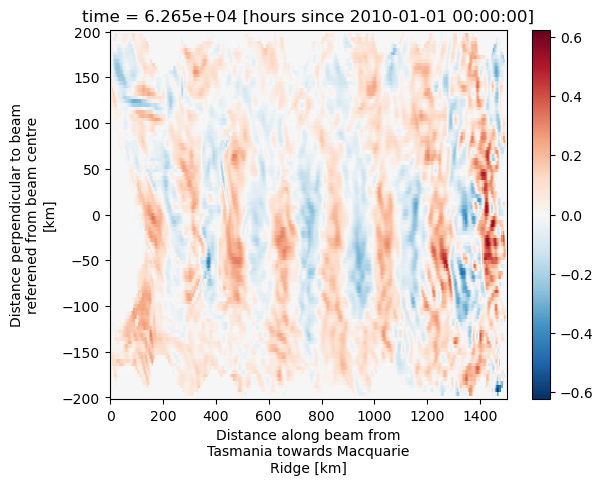

In [91]:
modes[1].isel(time = 50).integrate("zl").plot()